In [2]:
#!pip install polaris-ml
#!pip install fets
!pip install mlflow
#!pip install --upgrade pip
!pip install causalnex
#!python -c "import causalnex"
#!pip install torch
#!pip install graphviz
#!python -m pip install --global-option=build_ext --global-option="-IC:\Program Files\Graphviz\include" --global-option="-LC:\Program Files\Graphviz\lib" pygraphviz

ERROR: Could not find a version that satisfies the requirement causalnex (from versions: none)
ERROR: No matching distribution found for causalnex


In [2]:
from typing import Any, Hashable, List, Set, Tuple, Union

import networkx as nx
import numpy as np
from networkx.exception import NodeNotFound


def _validate_origin(origin: str) -> None:
    """
    Checks that origin has a valid value. One of:
        - unknown: edge exists for an unknown reason;
        - learned: edge was created as the output of a machine-learning process;
        - expert: edge was created by a domain expert.

    Args:
        origin: the value to validate.

    Raises:
        ValueError: if origin is not valid.
    """
    allowed = {"unknown", "learned", "expert"}

    if origin not in allowed:
        raise ValueError(f"Unknown origin: must be one of {allowed} - got `{origin}`.")


class StructureModel(nx.DiGraph):
    """
    Base class for structure models, which are an extension of ``networkx.DiGraph``.

    A ``StructureModel`` stores nodes and edges with optional data, or attributes.

    Edges have one required attribute, "origin", which describes how the edge was created.
    Origin can be one of either unknown, learned, or expert.

    StructureModel hold directed edges, describing a cause -> effect relationship.
    Cycles are permitted within a ``StructureModel``.

    Nodes can be arbitrary (hashable) Python objects with optional key/value attributes.
    By convention None is not used as a node.

    Edges are represented as links between nodes with optional key/value attributes.
    """

    def __init__(self, incoming_graph_data=None, origin="unknown", **attr):
        """
        Create a ``StructureModel`` with incoming_graph_data, which has come from some origin.

        Args:
            incoming_graph_data (Optional): input graph (optional, default: None)
                                 Data to initialize graph. If None (default) an empty graph is created.
                                 The data can be any format that is supported by the to_networkx_graph()
                                 function, currently including edge list, dict of dicts, dict of lists,
                                 NetworkX graph, NumPy matrix or 2d ndarray, SciPy sparse matrix, or PyGraphviz graph.

            origin (str): label for how the edges were created. Can be one of:
                        - unknown: edges exist for an unknown reason;
                        - learned: edges were created as the output of a machine-learning process;
                        - expert: edges were created by a domain expert.

            attr : Attributes to add to graph as key/value pairs (no attributes by default).
        """
        _validate_origin(origin)
        super().__init__(incoming_graph_data, **attr)

        for u_of_edge, v_of_edge in self.edges:
            self[u_of_edge][v_of_edge]["origin"] = origin

    def to_directed_class(self):
        """
        Returns the class to use for directed copies.
        See :func:`networkx.DiGraph.to_directed()`.
        """
        return StructureModel

    def to_undirected_class(self):
        """
        Returns the class to use for undirected copies.
        See :func:`networkx.DiGraph.to_undirected()`.
        """
        return nx.Graph

    # disabled: W0221: Parameters differ from overridden 'add_edge' method (arguments-differ)
    # this has been disabled because origin tracking is required for CausalGraphs
    # implementing it in this way allows all 3rd party libraries and applications to
    # integrate seamlessly, where edges will be given origin="unknown" where not provided
    def add_edge(
        self, u_of_edge: str, v_of_edge: str, origin: str = "unknown", **attr
    ):  # pylint: disable=W0221
        """
        Adds a causal relationship from u to v.

        If u or v do not currently exists in the ``StructureModel`` then they will be created.

        By default a relationship will be given origin="unknown", but
        may also be given "learned" or "expert" origin.

        Adding an edge that already exists will replace the existing edge.
        See :func:`networkx.DiGraph.add_edge`.

        Args:
            u_of_edge: causal node.
            v_of_edge: effect node.
            origin: label for how the edge was created. Can be one of:
                        - unknown: edge exists for an unknown reason;
                        - learned: edge was created as the output of a machine-learning process;
                        - expert: edge was created by a domain expert.
            **attr:  Attributes to add to edge as key/value pairs (no attributes by default).
        """
        _validate_origin(origin)

        attr.update({"origin": origin})
        super().add_edge(u_of_edge, v_of_edge, **attr)

    # disabled: W0221: Parameters differ from overridden 'add_edge' method (arguments-differ)
    # this has been disabled because origin tracking is required for CausalGraphs
    # implementing it in this way allows all 3rd party libraries and applications to
    # integrate seamlessly, where edges will be given origin="unknown" where not provided
    def add_edges_from(
        self,
        ebunch_to_add: Union[Set[Tuple], List[Tuple]],
        origin: str = "unknown",
        **attr,
    ):  # pylint: disable=W0221
        """
        Adds a bunch of causal relationships, u -> v.

        If u or v do not currently exists in the ``StructureModel`` then they will be created.

        By default relationships will be given origin="unknown",
        but may also be given "learned" or "expert" origin.

        Notes:
            Adding an edge that already exists will replace the existing edge.
            See :func:`networkx.DiGraph.add_edges_from`.

        Args:
            ebunch_to_add: container of edges.
                           Each edge given in the container will be added to the graph.
                           The edges must be given as 2-tuples (u, v) or
                           3-tuples (u, v, d) where d is a dictionary containing edge data.
            origin: label for how the edges were created. One of:
                        - unknown: edges exist for an unknown reason.
                        - learned: edges were created as the output of a machine-learning process.
                        - expert: edges were created by a domain expert.
            **attr:  Attributes to add to edge as key/value pairs (no attributes by default).
        """
        _validate_origin(origin)

        attr.update({"origin": origin})
        super().add_edges_from(ebunch_to_add, **attr)

    # disabled: W0221: Parameters differ from overridden 'add_edge' method (arguments-differ)
    # this has been disabled because origin tracking is required for CausalGraphs
    # implementing it in this way allows all 3rd party libraries and applications to
    # integrate seamlessly, where edges will be given origin="unknown" where not provided
    def add_weighted_edges_from(
        self,
        ebunch_to_add: Union[Set[Tuple], List[Tuple]],
        weight: str = "weight",
        origin: str = "unknown",
        **attr,
    ):  # pylint: disable=W0221
        """
        Adds a bunch of weighted causal relationships, u -> v.

        If u or v do not currently exists in the ``StructureModel`` then they will be created.

        By default relationships will be given origin="unknown",
        but may also be given "learned" or "expert" origin.

        Notes:
            Adding an edge that already exists will replace the existing edge.
            See :func:`networkx.DiGraph.add_edges_from`.

        Args:
            ebunch_to_add: container of edges.
                           Each edge given in the container will be added to the graph.
                           The edges must be given as 2-tuples (u, v) or
                           3-tuples (u, v, d) where d is a dictionary containing edge data.
            weight : string, optional (default='weight').
                     The attribute name for the edge weights to be added.
            origin: label for how the edges were created. One of:
                - unknown: edges exist for an unknown reason;
                - learned: edges were created as the output of a machine-learning process;
                - expert: edges were created by a domain expert.
            **attr: Attributes to add to edge as key/value pairs (no attributes by default).
        """
        _validate_origin(origin)

        attr.update({"origin": origin})
        super().add_weighted_edges_from(ebunch_to_add, weight=weight, **attr)

    def edges_with_origin(self, origin: List[Any]) -> List[Tuple[Any, Any]]:
        """
        List of edges created with given origin attribute.

        Returns:
            A list of edges with the given origin.
        """
        return [(u, v) for u, v in self.edges if self[u][v]["origin"] == origin]

    def remove_edges_below_threshold(self, threshold: float):
        """
        Remove edges whose absolute weights are less than a defined threshold.

        Args:
            threshold: edges whose absolute weight is less than this value are removed.
        """
        self.remove_edges_from(
            [(u, v) for u, v, w in self.edges(data="weight") if np.abs(w) < threshold]
        )

    def get_largest_subgraph(self) -> "StructureModel":
        """
        Get the largest subgraph of the Structure Model.

        Returns:
            The largest subgraph of the Structure Model. If no subgraph exists, None is returned.
        """
        largest_n_edges = 0
        largest_subgraph = None

        for component in nx.weakly_connected_components(self):
            subgraph = self.subgraph(component).copy()

            if len(subgraph.edges) > largest_n_edges:
                largest_n_edges = len(subgraph.edges)
                largest_subgraph = subgraph

        return largest_subgraph

    def get_target_subgraph(self, node: Hashable) -> "StructureModel":
        """
        Get the subgraph with the specified node.

        Args:
            node: the name of the node.

        Returns:
            The subgraph with the target node.

        Raises:
            NodeNotFound: if the node is not found in the graph.
        """
        if node in self.nodes:
            for component in nx.weakly_connected_components(self):
                subgraph = self.subgraph(component).copy()

                if node in set(subgraph.nodes):
                    return subgraph

        raise NodeNotFound(f"Node {node} not found in the graph.")

    def threshold_till_dag(self):
        """
        Remove edges with smallest weight until the graph is a DAG.
        Not recommended if the weights have different units.
        """
        while not nx.algorithms.is_directed_acyclic_graph(self):
            i, j, _ = min(self.edges(data="weight"), key=lambda x: abs(x[2]))
            self.remove_edge(i, j)

    def get_markov_blanket(
        self, nodes: Union[Any, List[Any], Set[Any]]
    ) -> "StructureModel":
        """
        Get Markov blanket of specified target nodes

        Args:
            nodes: Target node name or list/set of target nodes

        Returns:
            Markov blanket of the target node(s)

        Raises:
            NodeNotFound: if one of the target nodes is not found in the graph.
        """
        if not isinstance(nodes, (list, set)):
            nodes = [nodes]

        blanket_nodes = set()

        for node in set(nodes):  # Ensure target nodes are unique
            if node not in set(self.nodes):
                raise NodeNotFound(f"Node {node} not found in the graph.")

            blanket_nodes.add(node)
            blanket_nodes.update(self.predecessors(node))

            for child in self.successors(node):
                blanket_nodes.add(child)
                blanket_nodes.update(self.predecessors(child))

        blanket = StructureModel()
        blanket.add_nodes_from(blanket_nodes)
        blanket.add_weighted_edges_from(
            [
                (u, v, w)
                for u, v, w in self.edges(data="weight")
                if u in blanket_nodes and v in blanket_nodes
            ]
        )
        return blanket
    
    
print("Ok")


Ok


In [13]:
"""Plot Methods."""
import re
from collections import namedtuple
from copy import deepcopy
from typing import Dict, Tuple

import networkx as nx


def plot_structure(
    sm: nx.DiGraph,
    prog: str = "neato",
    all_node_attributes: Dict[str, str] = None,
    all_edge_attributes: Dict[str, str] = None,
    node_attributes: Dict[str, Dict[str, str]] = None,
    edge_attributes: Dict[Tuple[str, str], Dict[str, str]] = None,
    graph_attributes: Dict[str, str] = None,
):  # pylint: disable=missing-return-type-doc
    """
    Plot a `StructureModel` using pygraphviz.

    Return a pygraphviz graph from a StructureModel. The pygraphgiz graph
    is decorated and laid out so that it can be plotted easily.

    Default node, edge, and graph attributes are provided to style and layout
    the plot. These defaults can be overridden for all nodes and edges through
    `all_node_attributes` and `all_edge_attributes` respectively. Graph
    attributes can be overridden through `graph_attributes`.

    Styling and layout attributes can be set for individual nodes and edges
    through `node_attributes` and `edge_attributes` respectively.

    Attributes are set in the following order, overriding any previously set attributes
    1. default attributes
    2. all_node_attributes and all_edge_attributes
    3. node_attributes and edge_attributes
    4. graph_attributes

    Detailed documentation on available attributes and how they behave is available at:
    https://www.graphviz.org/doc/info/attrs.html

    Default style attributes provided in CausalNex are:

    - causalnex.plots.NODE_STYLE.NORMAL - default node stying
    - causalnex.plots.NODE_STYLE.WEAK - intended for less important nodes in structure
    - causalnex.plots.NODE_STYLE.STRONG - intended for more important nodes in structure

    - causalnex.plots.EDGE_STYLE.NORMAL - default edge stying
    - causalnex.plots.EDGE_STYLE.wEAK - intended for less important edges in structure
    - causalnex.plots.EDGE_STYLE.STRONG - intended for more important edges in structure

    - causalnex.plots.GRAPH_STYLE - default graph styling

    Example:
    ::
        >>> from causalnex.plots import plot_structure
        >>> plot = plot_structure(structure_model)
        >>> plot.draw("plot.png")

    Args:
        sm: structure to plot
        prog: Name of Graphviz layout program
        all_node_attributes: attributes to apply to all nodes
        all_edge_attributes: attrinbutes to apply to all edges
        node_attributes: attributes to apply to specific nodes
        edge_attributes: attributes to apply to specific edges
        graph_attributes: attributes to apply to the graph

    Returns:
        a styled pygraphgiz graph that can be rendered as an image

    Raises:
        Warning: Suggests mitigation strategies when ``pygraphviz`` is not installed.
    """

    # apply node and edge attributes
    _sm = _add_attributes(
        sm, all_node_attributes, all_edge_attributes, node_attributes, edge_attributes
    )

    # create plot
    try:
        a_graph = nx.nx_agraph.to_agraph(_sm)
    except ImportError as error_msg:
        raise Warning(
            """
            Pygraphviz not installed. Also make sure you have the system-level
            ``graphviz`` requirement installed.

            Alternatively, you can visualise your graph using the networkx.draw
            functionality:
            >>> sm = StructureModel()
            >>> fig, ax = plt.subplots()
            >>> nx.draw_circular(sm, ax=ax)
            >>> fig.show()
            """
        ) from error_msg

    # apply graph attributes
    a_graph.graph_attr.update(GRAPH_STYLE)
    if graph_attributes:
        a_graph.graph_attr.update(graph_attributes)

    # layout and return
    a_graph.layout(prog=prog)
    return a_graph


def color_gradient_string(from_color: str, to_color: str, steps: int) -> str:
    """
    Create a pygraphgiz compatible color gradient string.

    This string can be used when setting colors for nodes,
    edges, and graph attributes.

    Example:
    ::
        >>> node_attributes = {
        >>>    "color": color_gradient_string(
        >>>        from_color="#000000", to_color="#FFFFFF", steps=30
        >>>    )
        >>> }

    Args:
        from_color: rgb(a) string of color to start gradient from
        to_color: rgb(a) string of color to end gradient at
        steps: number of steps in the gradient string. steps=1 produces from_color:to_color
        without any intermediary steps

    Returns:
        a pygraphviz color gradient string
    """

    color_regex = re.compile(
        r"(#)([0-9a-fA-F]{2})([0-9a-fA-F]{2})([0-9a-fA-F]{2})([0-9a-fA-F]{2})*"
    )

    from_colors = [
        int(v, 16) if v else 0 for v in color_regex.match(from_color).groups()[1:]
    ]
    to_colors = [
        int(v, 16) if v else 0 for v in color_regex.match(to_color).groups()[1:]
    ]

    delta_colors = [(t - f) / steps for f, t in zip(from_colors, to_colors)]

    gradient_colors = [
        "#"
        + "".join(
            [format(int(f + d * i), "02x") for f, d in zip(from_colors, delta_colors)]
        )
        for i in range(steps + 1)
    ]

    return ":".join(
        [f"{gradient_colors[i]};{1 / (steps + 1):.2f}" for i in range(steps + 1)]
    )


def _add_attributes(
    sm: nx.DiGraph,
    all_node_attributes: Dict[str, str] = None,
    all_edge_attributes: Dict[str, str] = None,
    node_attributes: Dict[str, Dict[str, str]] = None,
    edge_attributes: Dict[str, Dict[str, str]] = None,
) -> nx.DiGraph:
    _sm = deepcopy(sm)

    # shift labels to be above nodes
    for node in _sm.nodes:
        _sm.nodes[node]["label"] = f"{node}\n\n "

    # apply node attributes (start with default, then apply any custom)
    _all_node_attr = {**NODE_STYLE.NORMAL}
    if all_node_attributes:
        _all_node_attr.update(all_node_attributes)

    for k, v in _all_node_attr.items():
        nx.set_node_attributes(_sm, v, k)

    # apply edge attributes (start with default, then apply any custom)
    _all_edge_attr = {**EDGE_STYLE.NORMAL}
    if all_edge_attributes:
        _all_edge_attr.update(all_edge_attributes)

    for k, v in _all_edge_attr.items():
        nx.set_edge_attributes(_sm, v, k)

    # apply specific node and edge attributes
    if node_attributes:
        nx.set_node_attributes(_sm, node_attributes)
    if edge_attributes:
        nx.set_edge_attributes(_sm, edge_attributes)

    return _sm


GRAPH_STYLE = {
    "bgcolor": "#001521",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "splines": True,
    "overlap": "scale",
    "scale": 2.0,
    "pad": "0.8,0.3",
    "dpi": 300,
}

_style = namedtuple("Style", ["WEAK", "NORMAL", "STRONG"])

NODE_STYLE = _style(
    {
        "fontcolor": "#FFFFFF8c",
        "fontname": "Helvetica",
        "shape": "circle",
        "fixedsize": True,
        "style": "filled",
        "fillcolor": "#4a90e2d9",
        "color": "#FFFFFFD9",
        "width": 0.05,
        "penwidth": "1",
        "fontsize": 10,
    },
    {
        "fontcolor": "#FFFFFFD9",
        "fontname": "Helvetica",
        "shape": "circle",
        "fixedsize": True,
        "style": "filled",
        "fillcolor": "#4a90e2d9",
        "color": "#4a90e220",
        "width": 0.15,
        "penwidth": "20",
        "fontsize": 15,
    },
    {
        "fontcolor": "#4a90e2",
        "fontname": "Helvetica",
        "shape": "circle",
        "fixedsize": True,
        "style": "filled",
        "fillcolor": "#4a90e2d9",
        "color": "#4a90e2",
        "width": 0.15,
        "penwidth": "4",
        "fontsize": 20,
    },
)

EDGE_STYLE = _style(
    {
        "color": color_gradient_string("#FFFFFF33", "#ffffffaa", 30),
        "arrowhead": "normal",
        "penwidth": 0.25,
        "arrowsize": 0.4,
    },
    {
        "color": color_gradient_string("#FFFFFF33", "#ffffffaa", 30),
        "arrowhead": "normal",
        "penwidth": 1,
        "arrowsize": 0.8,
    },
    {
        "color": color_gradient_string("#FFFFFF33", "#1F78B4aa", 30),
        "arrowhead": "normal",
        "penwidth": 3,
        "arrowsize": 1,
    },
)

print("Ok")

Ok


In [5]:

!python -m pip install --global-option=build_ext --global-option="-IC:\Program Files\Graphviz\include" --global-option="-LC:\Program Files\Graphviz\lib" pygraphviz
!pip install causalnex

import warnings

from causalnex.structure import StructureModel
warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

print("Ok")


ERROR: Could not find a version that satisfies the requirement causalnex (from versions: none)
ERROR: No matching distribution found for causalnex


ModuleNotFoundError: No module named 'causalnex'

In [15]:

sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

print("Ok")


Ok


In [6]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

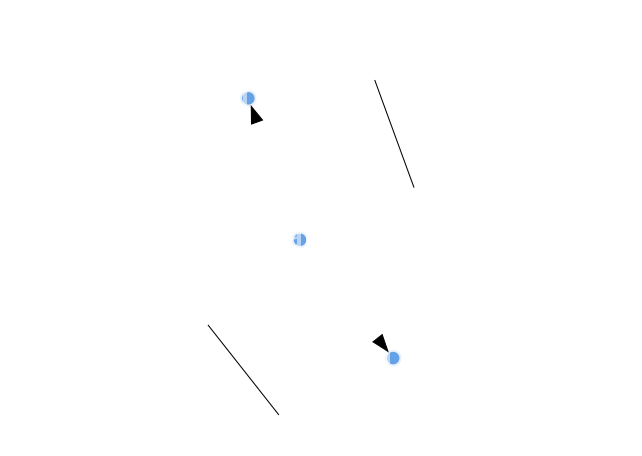

In [16]:

from IPython.display import Image

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [8]:
import pandas as pd

data = pd.read_csv('student-por.csv', delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [9]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


In [10]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


In [12]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(struct_data)

print("Ok")

ModuleNotFoundError: No module named 'causalnex'

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

In [ ]:

sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [ ]:
sm = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)
print("Ok")

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))